# Data Exploration


In [ ]:
# Setup cell and basic imports

from iragca.matplotlib import Styles
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Directories are enums for `pathlib.Path` objects
from lib.config import Directories

# We use an opinionated style for plotting
plt.style.use(Styles.ML.value)

This notebook introduces and interfaces the data and does light exploration of its characteristics. Right after downloading the dataset, we can import either of the 3 datsets:

- `MegaPlantDataset` contains both healthy and unhealthy leaf images and is designed for binary classification.
- `UnhealthyMegaPlantdataset` contains only the unhealthy leaf images but has 12 classes of plant disease symptoms, designed for multi-class classification for symptom-identification.
- `CombinedMegaPlantDataset` contains both healthy class and unhealthy subclass images, designed for both plant disease detection and symptom-identification.


In [ ]:
from lib.data import MegaPlantDataset, UnhealthyMegaPlantDataset, CombinedMegaPlantDataset

MEGAPLANT_DIR = Directories.EXTERNAL_DATA_DIR.value / "huggingface" / "leaves"

megaplant = MegaPlantDataset(
    data_path=MEGAPLANT_DIR, transforms=None
    )

unhealthy_megaplant = UnhealthyMegaPlantDataset(
    data_path=MEGAPLANT_DIR, transforms=None
    )

combined_megaplant = CombinedMegaPlantDataset(
    data_path=MEGAPLANT_DIR, transforms=None
    )

As we have mentioned in our paper, we compiled the dataset according to some criteria regarding the folder names whether they have a corresponding name in the 12 unhealthy subclasses.

We counted the retrieved images by using this command inside a Bash terminal.

`find path/to/dir -type f | wc -l`

| Dataset      | Reported size | Retrieved images |
| ------------ | ------------- | ---------------- |
| DiaMOS       | 3,901         | 3,006            |
| PlantVillage | 54,305        | 54,306           |
| PlantDoc     | 2,922         | 2,598            |

Due to duplicates, corrupted images, we receive different counts of images rather than the ones reported in the original authors' papers.


## Sample Images

We can index and iterate over the dataset, and each sample is a `tuple` of `(image, label)` dataset. If `transforms=None` then `image` will be a `pathlib.Path` object. Otherwise, it will be whatever `torchvision.transforms` output will be. `label` will always be the image's label.

Label: 0


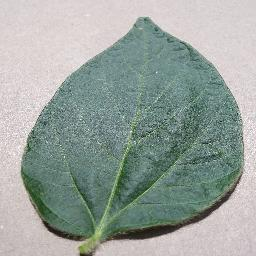

In [8]:
image, label = megaplant[0]

print("Label:", label)
Image.open(image)

In [10]:
megaplant.STATUS_MAP

{'healthy': 0, 'unhealthy': 1}

This image from the `MegaPlantDataset` is of label `0` indicating that it is health, and `1` if otherwise.

Label: 10


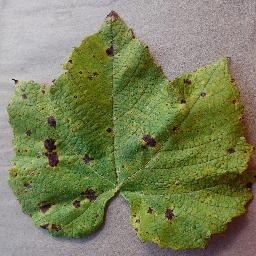

In [26]:
image, label = unhealthy_megaplant[-2007]

print("Label:", label)
Image.open(image)

In [12]:
unhealthy_megaplant.SYMPTOM_MAP

{'blight': 0,
 'yellowing': 1,
 'malformation': 2,
 'powdery_mildew': 3,
 'feeding': 4,
 'mold': 5,
 'mosaic': 6,
 'rot': 7,
 'rust': 8,
 'scab': 9,
 'spot': 10,
 'scorch': 11}

This image from the `UnhealthyMegaPlantDataset` is of class `10`, meaning it has a symptom of 'spots'.

Label: 0


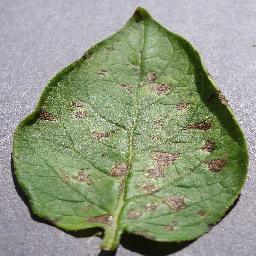

In [12]:
image, label = combined_megaplant[0]

print("Label:", label)
Image.open(image)

In [13]:
combined_megaplant.CLASS_MAP

{'blight': 0,
 'yellowing': 1,
 'malformation': 2,
 'powdery_mildew': 3,
 'feeding': 4,
 'mold': 5,
 'mosaic': 6,
 'rot': 7,
 'rust': 8,
 'scab': 9,
 'spot': 10,
 'scorch': 11,
 'healthy': 12}

This image from the `CombinedMegaPlantDataset` is of class `0`, meaning it has a symptom of 'blight', indicating that it has a disease. If otherwise it had a class of 12, it would have no disease or symptom.

## Analysis


The analysis we will perform are some simple descriptive statistics about the dataset itself, as well as statistics about image metadata such as resolution or image channels.

### Sample Sizes

In [4]:
print("MegaPlantDataset size:", len(megaplant))
print("UnhealthyMegaPlantDataset size:", len(unhealthy_megaplant))
print("CombinedMegaPlantDataset size:", len(combined_megaplant))

MegaPlantDataset size: 60206
UnhealthyMegaPlantDataset size: 44270
CombinedMegaPlantDataset size: 60206


We have 60,000 images of leaves both healthy, and unhealthy.

Unhealthy portion:  0.7353087732119722
Healthy portion:  0.26469122678802776


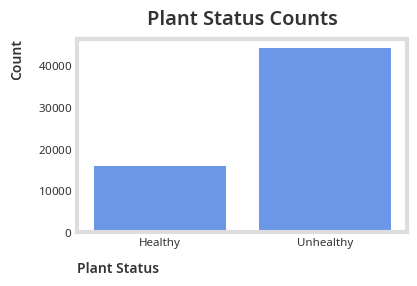

In [5]:
from collections import defaultdict

# Make a frequency count of statuses and symptoms
status_counts = defaultdict(int)
class_counts = defaultdict(int)
symptom_int_map = {v: k for k, v in unhealthy_megaplant.SYMPTOM_MAP.items()}

for _, label in megaplant:
    status_counts[label] += 1

for _, label in combined_megaplant:
    class_counts[label] += 1

# Plot status counts
sns.barplot(
    x=list(status_counts.keys()),
    y=list(status_counts.values()),
)
plt.xlabel("Plant Status")
plt.ylabel("Count")
plt.title("Plant Status Counts")
plt.xticks(ticks=[0, 1], labels=["Healthy", "Unhealthy"])

print("Unhealthy portion: ", status_counts[1] / sum(status_counts.values()))
print("Healthy portion: ", status_counts[0] / sum(status_counts.values()))

A 3:1 ratio between the unhealthy and healthy class implies a significant class imbalance.

Text(0.5, 1.0, 'Class Counts')

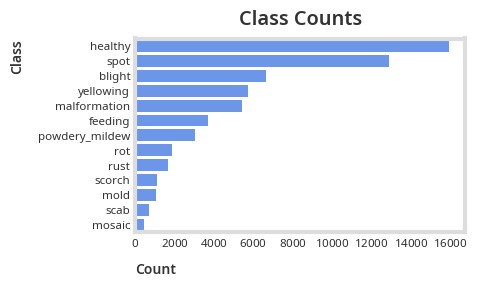

In [11]:
sorted_class_counts = dict(
    sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
)
class_int_map = {v: k for k, v in combined_megaplant.CLASS_MAP.items()}
sns.barplot(
    y=[class_int_map[k] for k in sorted_class_counts.keys()],
    x=list(sorted_class_counts.values()),
    orient="h"
)
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Class Counts")

A [Pareto](https://en.wikipedia.org/wiki/Pareto_principle) like pattern emerges in the class counts, with spot and blight symptoms composing around 50% of the unhealthy leaf images.

Considering that classes are imbalanced both for all 3 datasets, it is imperative that we use performance metrics like [Precision, Recall](https://en.wikipedia.org/wiki/Precision_and_recall) and [F1 Score](https://en.wikipedia.org/wiki/F-score) to capture in-class prediction accuracy to mitigate misleading conclusion due to class majority bias rather than solely relying on overall [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision).

### Image Metadata

In [53]:
sizes_freq = defaultdict(int)
channel_freq = defaultdict(int)

for image, label in unhealthy_megaplant:
    image_size = Image.open(image).size
    sizes_freq[image_size] += 1

    channel_freq[len(Image.open(image).getbands())] += 1

sizes_freq = dict(sorted(sizes_freq.items(), key=lambda item: item[1], reverse=True))
channel_freq = dict(sorted(channel_freq.items(), key=lambda item: item[0]))

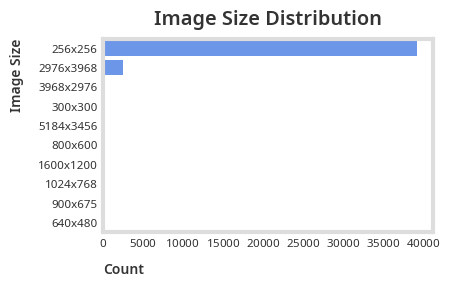

In [54]:
TOP_K = 10
sns.barplot(
    y=[f"{size[0]}x{size[1]}" for size in list(sizes_freq.keys())[:TOP_K]],
    x=list(sizes_freq.values())[:TOP_K],
    orient="h"
)
plt.xlabel("Count")
plt.ylabel("Image Size")
plt.title("Image Size Distribution")
plt.show()

We can see that most of our images are sized `256x256` and will need preprocessing before passing it through a convolutional network.

Channel counts: {1: 1, 3: 44260, 4: 9}


Text(0.5, 1.0, 'Channel Count Distribution')

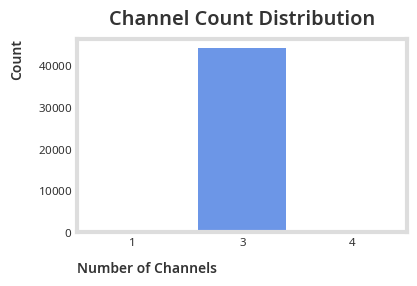

In [58]:
print("Channel counts:", channel_freq)
sns.barplot(
    x=list(channel_freq.keys()),
    y=list(channel_freq.values()),
)
plt.xlabel("Number of Channels")
plt.ylabel("Count")
plt.title("Channel Count Distribution")

Most of our images have 3 channels (`RGB` or colored).

## Summary

We've shown how to import the datasets, and use their interface including iterating and indexing, we also explored its characteristics, leaving with the information that our data's class imbalance is significant and is imperative that we use class imbalance agnostic performance metrics like Precision, Recall and F1 Score. We also discovered that we will need to do preprocessing before modeling due to different image resolutions and channels.